In [1]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt 
from plot_function import *
from itertools import cycle
from pathlib import Path
from datetime import date

In [2]:
connection = sqlite3.connect('./sample_database.db')
c = connection.cursor()

In [3]:
sample = pd.read_sql_query("""SELECT * FROM tc_fit_results""", con=connection)
amp_sweeps = pd.read_sql_query("""SELECT * FROM amp_sweep_info""", con=connection)
solvents = pd.read_sql_query("SELECT * FROM solvent_infos", con=connection)
dilu = pd.read_sql_query("""SELECT sample_prep_info.*, 
                                   dilution_series.dilution_serie
                            FROM sample_prep_info
                            LEFT JOIN dilution_series USING (sample_ID)
                         """, con=connection)
frq_sweeps = pd.read_sql("select * from frq_sweep_info", con=connection)
flow_curves = pd.read_sql("select * from flow_curves", con=connection)

In [4]:
sample.head()

sample_ID  temperature  yield_stress_TC  err_yield_stress_TC  \
0  20210716004           20         3.591407             0.044424   
1  20210716005           20         6.102649             0.032709   
2  20210716001           20         0.279250             0.006662   
3  20210716006           20         8.972668             0.054836   
4  20210716008           20        71.293168             0.701223   

   caract_shear_rate  err_caract_shear_rate   viscinf  err_viscinf  \
0           0.033843               0.001290  0.438752     0.021952   
1           0.070663               0.001289  0.453216     0.013419   
2           0.000591               0.000035  0.730914     0.021153   
3           0.111220               0.002398  0.431936     0.018327   
4           0.622501               0.024922  0.054173     0.101427   

   crit_strain_TC  err_crit_strain_TC  
0        0.004134            0.000416  
1        0.005248            0.000279  
2        0.001547            0.000174  
3        0.005354            0.000375  
4        0.000473            0.000909

# Effect of temperature 

## on both critical strains

In [5]:
df = pd.merge(left=sample, right=amp_sweeps, on=['sample_ID', 'temperature'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df = pd.merge(left=df, right=dilu, on=['sample_ID'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df = pd.merge(left=df, right=solvents, on=['solvent', 'temperature'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df.tail()

sample_ID  temperature  yield_stress_TC  err_yield_stress_TC  \
47  20220204001           20       131.830084                  NaN   
48  20220207002           20         0.727337             0.007076   
49  20220207001           20        69.719353                  NaN   
50  20220209001           20        18.222818                  NaN   
51  20220214001           20       153.294625                  NaN   

    caract_shear_rate  err_caract_shear_rate       viscinf  err_viscinf  \
47           6.882097                    NaN  1.275301e-08          NaN   
48           0.319390               0.013523  5.416018e-02     0.001964   
49           7.407036                    NaN  1.484790e-08          NaN   
50           3.339953                    NaN  1.000020e-08          NaN   
51           4.157947                    NaN  1.006446e-08          NaN   

    crit_strain_TC  err_crit_strain_TC  crit_strain_intersect  \
47    6.657620e-10                 NaN               0.192586   
48    2.378292e-02            0.002101               0.099650   
49    1.577452e-09                 NaN               0.156802   
50    1.832877e-09                 NaN               0.110722   
51    2.729874e-10                 NaN               0.110722   

    crit_strain_10percent solvent microgel_type  w_percent  \
47               0.125760   water    big~pnipam       10.0   
48               0.015859   water    big~pnipam        5.0   
49               0.031637   water    big~pnipam        8.0   
50               0.063145   water    big~pnipam        7.0   
51               0.063145   water    big~pnipam       13.0   

         dilution_serie  solvent_viscosity  
47  big~pnipam~in~water              0.001  
48  big~pnipam~in~water              0.001  
49  big~pnipam~in~water              0.001  
50  big~pnipam~in~water              0.001  
51  big~pnipam~in~water              0.001

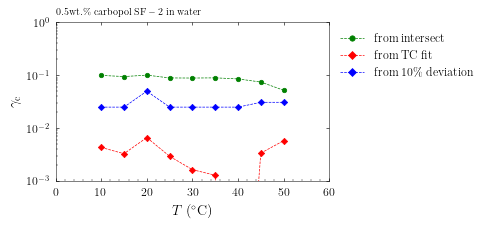

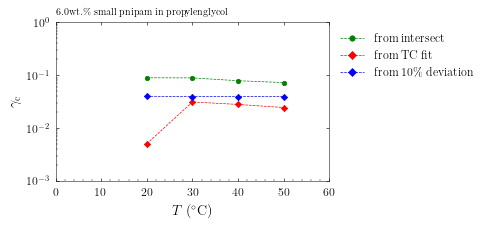

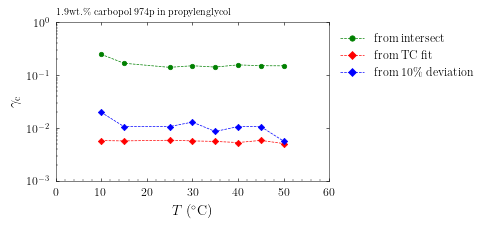

In [6]:
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        fig, ax, _, _ = create_plot()
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        ax.plot(unq_sample.temperature, unq_sample.crit_strain_intersect,
                ls='--', marker='o', c='g', mfc='g', label='$\mathrm{from~intersect}$')
        ax.plot(unq_sample.temperature, unq_sample.crit_strain_TC, ls='--', marker='D', c='r', mfc='r', label='$\mathrm{from~TC~fit}$')
        ax.plot(unq_sample.temperature, unq_sample.crit_strain_10percent, ls='--', marker='D', c='b', mfc='b', label='$\mathrm{from~10\%~deviation}$')

        ax.legend(bbox_to_anchor=(1,1))        
        ax.annotate(f'${concentration}\mathrm{{wt.}}\% \mathrm{{~{microgel}~in~{solvent}}}$', (0, 1.05), xycoords="axes fraction")  
        ax.set(yscale='log',
               xlabel=r'$T~(^\circ \mathrm{C})$',
               ylabel=r'$\gamma_\mathrm{c}$',
               xlim=(0, 60), ylim=(1e-3, 1)
                )
        #
        # fig.savefig(f'cri_strains_temperature_{solvent}_{microgel}.png', bbox_inches='tight', dpi=200)
        plt.show()
        plt.close()

## on yield stress

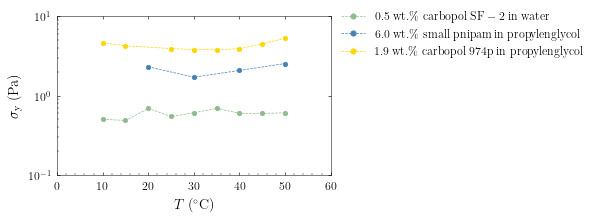

In [7]:
fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.yield_stress_TC,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\sigma_\mathrm{y}~\mathrm{(Pa)}$',
       xlim=(0, 60), ylim=(1e-1, 10)
       )
#fig.savefig(f'yield_stress_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

## on viscosities

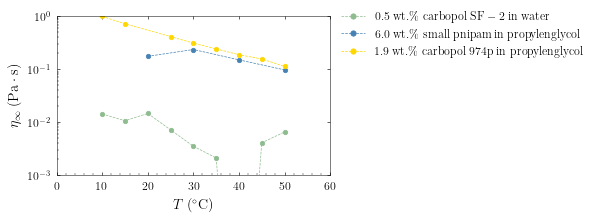

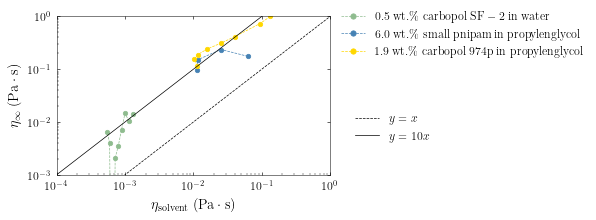

In [8]:
#----------------
# En fonction de la temperature
#----------------

fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.viscinf,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\eta_\infty~\mathrm{(Pa \cdot s)}$',
       xlim=(0, 60), ylim=(1e-3, 1)
       )
#fig.savefig(f'eta_infinity_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

#----------------
# En fonction de la viscosité du solvant
#----------------

fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.solvent_viscosity, unq_sample.viscinf,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
        
x=np.logspace(-4, 0, 10)
ax.plot(x, x, ls='--', c='k', marker='')
ax.plot(x, 10*x, ls='-', c='k', marker='')
handles = [mpl.lines.Line2D([], [], marker='', c='k', ls='--', label=f'$y=x$'),
           mpl.lines.Line2D([], [], marker='', c='k', ls='-', label=f'$y=10x$')]
legend = fig.legend(handles=handles, bbox_to_anchor=(1, 0.5))



ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xscale='log',
       xlabel=r'$\eta_\mathrm{solvent}~(\mathrm{Pa \cdot s})$',
       ylabel=r'$\eta_\infty~\mathrm{(Pa \cdot s)}$',
       xlim=(1e-4, 1), ylim=(1e-3, 1)
       )
#fig.savefig(f'eta_infinity_eta_solvent.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

## on caracteristic shear rates

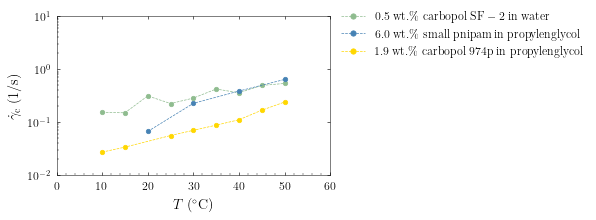

In [9]:
fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in df.sample_ID.unique():
    unq_sample = df[df.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvent)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.caract_shear_rate,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\dot{\gamma}_\mathrm{c}~\mathrm{(1/s)}$',
       xlim=(0, 60), ylim=(1e-2, 10)
       )
#fig.savefig(f'gammadotc_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

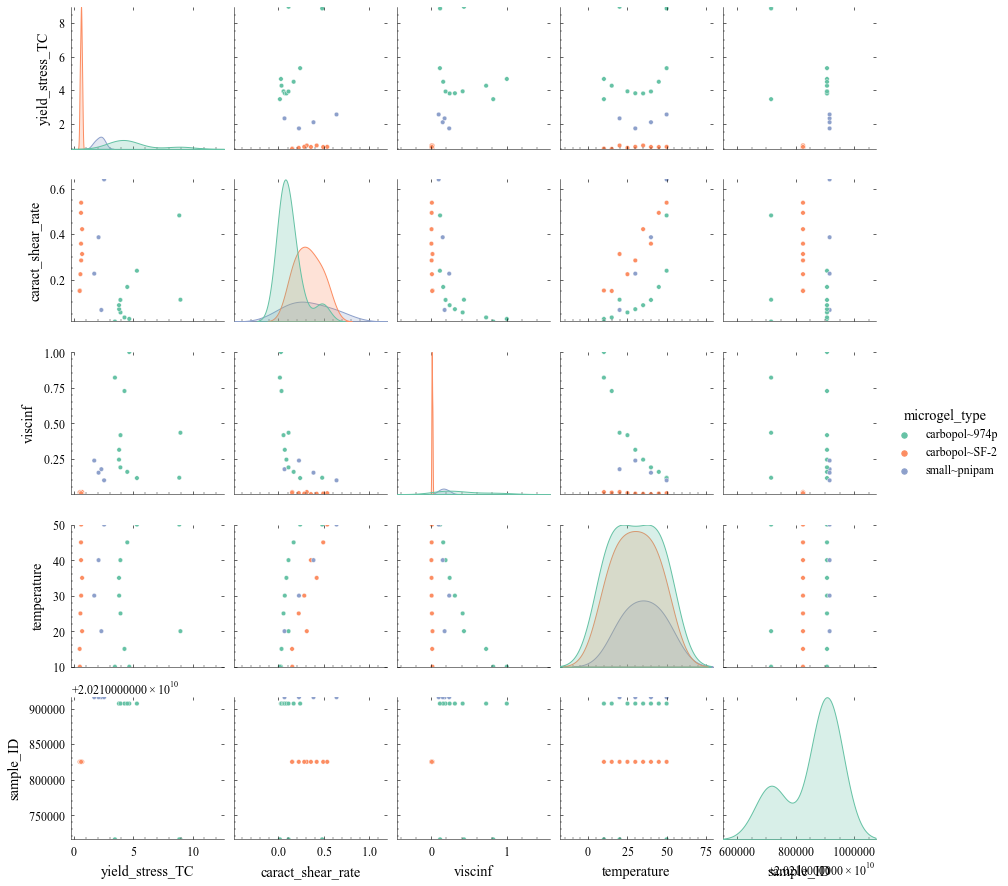

In [10]:
import seaborn as sns
from matplotlib import rc
rc('text', usetex=False)

test = df.loc[:, ['yield_stress_TC', 'caract_shear_rate', 'viscinf', 'temperature', 'microgel_type', 'sample_ID']]
for sample_ID in test.sample_ID.unique():
    if len(test[test.sample_ID == sample_ID]) <= 1:
        test = test[test.sample_ID != sample_ID]


sns.pairplot(test.loc[:, ['yield_stress_TC', 'caract_shear_rate', 'viscinf', 'temperature', 'microgel_type', 'sample_ID']], hue="microgel_type", palette="Set2")
#plt.savefig('test.png', dpi=200)

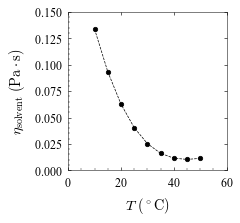

In [11]:
PG = solvents.query("solvent == 'propylenglycol'")
PG = PG.sort_values('temperature')
fig, ax, _, _ = create_plot(two_sided=True)
ax.plot(PG.temperature, PG.solvent_viscosity, c='k', ls='--', mfc='k')
ax.set(xlim=(0, 60), ylim=(0, 0.15), 
       xlabel='$T~(^\circ \mathrm{C})$', ylabel='$\eta_\mathrm{solvent}~\mathrm{(Pa \cdot s)}$')
fig.savefig('solvent_visc.svg', bbox_inches = 'tight')